<a href="https://colab.research.google.com/github/annkamsk/ASD-problems/blob/master/Ass3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import pandas as pd 
from pandas import IntervalDtype
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset

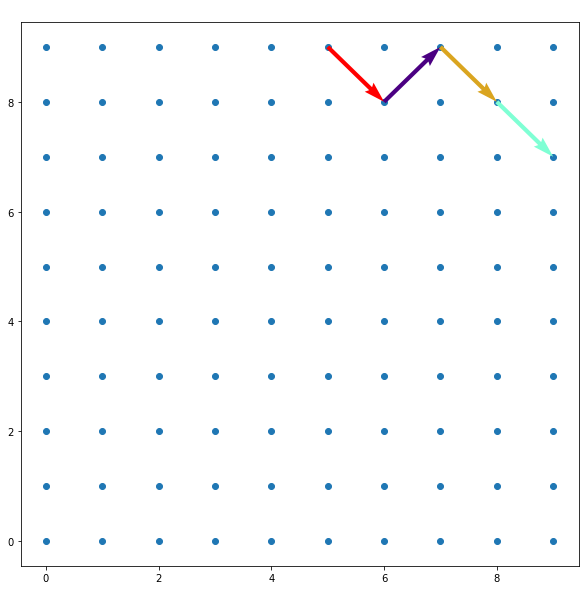

In [0]:
TRAIN_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/train_x.csv'
TRAIN_LABEL_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/train_y.csv'
TEST_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/test_x.csv'
TEST_LABEL_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/test_y.csv'
BEST_PATH = '/content/drive/My Drive/MIM/dl_lab/ass3/best.pth'

class Config:
  def __init__(self, bs=4, epochs=5, output=4, inputs=2, hidden=2, seq_len=5, layers=1, trunc=False, embedding=False, vocab_size=0, embedding_dim=2, lr=0.0005):
    self.bs = bs
    self.epochs = epochs
    self.output = output
    self.inputs = inputs
    self.hidden = hidden
    self.seq_len = seq_len
    self.layers = layers
    self.trunc = trunc
    self.embedding = embedding
    self.embedding_dim = embedding_dim
    self.lr = lr
    self.vocab_size = vocab_size


class MyDataset(Dataset):
    def __init__(self, data, col):
        self.data = data
        self.label = col

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.label[index]


train_csv = pd.read_csv(TRAIN_PATH, header=None).values
train_labels_csv = pd.read_csv(TRAIN_LABEL_PATH,header=None,dtype=np.int64).values
test_csv = pd.read_csv(TEST_PATH, header=None).values
test_labels_csv = pd.read_csv(TEST_LABEL_PATH,header=None,dtype=np.int64).values

train_dt = []
for row in train_csv:
  train_dt.append([[int(v) for v in val.split('-')] for val in row])
train_dt = np.array(train_dt)

test_dt = []
for row in test_csv:
  test_dt.append([[int(v) for v in val.split('-')] for val in row])
test_dt = np.array(test_dt)

train_torch = torch.from_numpy(train_dt)
target_torch = torch.from_numpy(train_labels_csv)
test_torch = torch.from_numpy(test_dt)
test_target_torch = torch.from_numpy(test_labels_csv)

train_dt = MyDataset(train_torch, target_torch)
train_loader = DataLoader(train_dt, batch_size = Config().bs, shuffle=True)
test_dt = MyDataset(test_torch, test_target_torch)
test_loader = DataLoader(test_dt, batch_size = Config().bs, shuffle=False)

def show_movement(row, label, size=10):
  xx, yy = np.meshgrid(np.arange(size), np.arange(size), indexing='ij')

  def get_mesh(row):
    V = []
    row = np.array(row)
    originX, originY = [], []
    for a, b in zip(row, row[1:]):
      originX.append(a[0])
      originY.append(a[1])
      vec = b - a
      V.append([vec[0], vec[1]])
    return np.array(V), np.array(originX), np.array(originY)

  Z, oX, oY = get_mesh(row)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.scatter(xx, yy)
  plt.quiver(oX, oY, Z[:,0], Z[:,1], color=['r','indigo','goldenrod','aquamarine'], angles='xy', scale_units='xy', scale=1)
  plt.title(label, color='w')
  plt.show()

items = iter(train_loader).next()
show_movement(items[0][0], items[1][0])


## Data analysis
3: LD, RG, RD, LG  (to the bottom left?)  
1: (to the upper left), RD, RG, LG, LG; LD, LG, LD, LG  
0: (to the upper right?), LG, RG, RG, RD; RGx4    
2: (to bottom right) RG, LG, RD, LD; 
RD, RD, LD, RD; 
RD, LG, RG, RG  

In [0]:
import random

class RNNet(nn.Module):
  def __init__(self, config):
    super(RNNet, self).__init__()
    self.input_size = config.inputs
    self.output_size = config.output
    self.layers = config.layers
    self.hidden_dim = config.hidden
    self.bs = config.bs
    self.trunc = config.trunc
    random.seed()
    self.lstm = nn.LSTM(
        input_size=self.input_size, 
        hidden_size=self.hidden_dim, 
        num_layers=self.layers,
        batch_first=True)
    self.seq = nn.Linear(self.hidden_dim, self.output_size)
  
  def init_hidden(self):
    h = Variable(torch.zeros(self.layers, self.bs, self.hidden_dim).cuda())
    c = Variable(torch.zeros(self.layers, self.bs, self.hidden_dim).cuda())
    return (h, c)

  def pad_input(self, x):
    # using variable seq lengths: https://stackoverflow.com/a/49473068/7196167
    if self.trunc and random.random() >= 0.5:
      x = x[:,:4,:]
      seq_lengths = [4] * self.bs
    else:
      seq_lengths = [5] * self.bs
    res = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True)
    return res

  def forward(self, x):
    x = x.float()
    lstm_input = self.pad_input(x)
    # x = (bs, seq_len=5, feature=2)
    lstm_out, hidden = self.lstm(lstm_input, self.init_hidden())
    lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
    y = self.seq(lstm_out[:, -1, :])
    return y


- input dimension: nr of variables (2)
- hidden dimension: size of hidden and cell state at each time step
- nr of layers (default 1)
- output dimension: nr of classes (4)
lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

## Train definition

In [0]:

def test(model, te_l):
  correct, total = 0., 0.
  for data, target in te_l:
    data, target = data.cuda(), target.cuda()
    out = model(data)
    preds = F.log_softmax(out, dim=1).argmax(dim=1)
    total += target.size(0)
    correct += (preds == target.squeeze()).sum().item()
  return correct / total

def train_epoch(model, tr_l, te_l, optimizer, criterion, epoch, best):
  total, total_correct = 0., 0.
  for idx, (data, target) in enumerate(tr_l):
    model.train()
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target.squeeze())
    loss.backward()
    optimizer.step()

    if idx % 50 == 0:
      model.eval()
      acc = test(model, te_l)
      if acc > best:
        best = acc
        torch.save(model.state_dict(), BEST_PATH)
      if idx % 500 == 0:
        print('Train epoch {}, idx: {}\t Loss {:.4f}\t Acc: {:.2f}%'.format(
            epoch,
            idx,
            loss.item(),
            acc * 100
        ))
  print(best)

def train(model, conf, tr_l, te_l):
  lr = conf.lr
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  best = 0.0
  for epoch in range(conf.epochs):
    train_epoch(model, tr_l, te_l, optimizer, criterion, epoch, best)



## Train on raw data - truncated

In [0]:
conf_raw_trunc = Config(bs=4, epochs=1, output=4, inputs=2, hidden=256, seq_len=5, layers=1, trunc=True)
model = RNNet(conf)
model.cuda()
train(model, conf_raw_trunc, train_loader, test_loader)

Train epoch 0, idx: 0	 Loss 1.3931	 Acc: 25.40%
Train epoch 0, idx: 100	 Loss 1.2534	 Acc: 42.40%
Train epoch 0, idx: 200	 Loss 1.2419	 Acc: 53.00%
Train epoch 0, idx: 300	 Loss 0.9298	 Acc: 51.20%
Train epoch 0, idx: 400	 Loss 1.2242	 Acc: 51.80%
Train epoch 0, idx: 500	 Loss 1.0357	 Acc: 55.50%
Train epoch 0, idx: 600	 Loss 1.5541	 Acc: 59.60%
Train epoch 0, idx: 700	 Loss 0.8819	 Acc: 59.40%
Train epoch 0, idx: 800	 Loss 0.9937	 Acc: 55.30%
Train epoch 0, idx: 900	 Loss 1.6339	 Acc: 58.60%
Train epoch 0, idx: 1000	 Loss 0.6533	 Acc: 62.80%
Train epoch 0, idx: 1100	 Loss 0.7203	 Acc: 62.90%
Train epoch 0, idx: 1200	 Loss 1.3945	 Acc: 62.70%
Train epoch 0, idx: 1300	 Loss 1.5061	 Acc: 63.20%
Train epoch 0, idx: 1400	 Loss 0.9704	 Acc: 64.30%
Train epoch 0, idx: 1500	 Loss 1.1070	 Acc: 63.60%
Train epoch 0, idx: 1600	 Loss 1.2033	 Acc: 64.80%
Train epoch 0, idx: 1700	 Loss 0.7492	 Acc: 61.90%
Train epoch 0, idx: 1800	 Loss 0.8129	 Acc: 64.60%
Train epoch 0, idx: 1900	 Loss 0.6871	 Acc:

## Train on raw data - not truncated

In [0]:
conf_raw = Config(bs=4, epochs=5, output=4, inputs=2, hidden=256, seq_len=5, layers=1, trunc=False)
model = RNNet(conf)
model.cuda()
train(model, conf_raw, train_loader, test_loader)

Train epoch 0, idx: 0	 Loss 1.3792	 Acc: 24.90%
Train epoch 0, idx: 100	 Loss 1.0769	 Acc: 45.30%
Train epoch 0, idx: 200	 Loss 0.9148	 Acc: 51.40%
Train epoch 0, idx: 300	 Loss 1.0761	 Acc: 61.50%
Train epoch 0, idx: 400	 Loss 0.9671	 Acc: 58.90%
Train epoch 0, idx: 500	 Loss 1.1472	 Acc: 65.20%
Train epoch 0, idx: 600	 Loss 1.1468	 Acc: 64.90%
Train epoch 0, idx: 700	 Loss 1.2790	 Acc: 66.20%
Train epoch 0, idx: 800	 Loss 0.5091	 Acc: 62.20%
Train epoch 0, idx: 900	 Loss 1.6837	 Acc: 67.10%
Train epoch 0, idx: 1000	 Loss 1.0141	 Acc: 67.00%
Train epoch 0, idx: 1100	 Loss 0.7244	 Acc: 63.30%
Train epoch 0, idx: 1200	 Loss 0.9620	 Acc: 62.90%
Train epoch 0, idx: 1300	 Loss 1.8673	 Acc: 62.00%
Train epoch 0, idx: 1400	 Loss 0.9960	 Acc: 63.50%
Train epoch 0, idx: 1500	 Loss 1.1523	 Acc: 66.40%
Train epoch 0, idx: 1600	 Loss 0.7686	 Acc: 67.40%
Train epoch 0, idx: 1700	 Loss 1.5153	 Acc: 67.00%
Train epoch 0, idx: 1800	 Loss 0.7608	 Acc: 66.80%
Train epoch 0, idx: 1900	 Loss 0.7094	 Acc:

## Input data with distinct random nrs assigned

In [0]:
from numpy.random import default_rng

class IntegerDataset(MyDataset):
  rng = default_rng()
  points = np.array(rng.choice(100, size=100, replace=False)).reshape((10, 10))
  def __to_int__(self, row):
    return np.array([points[xy[0], xy[1]] for xy in row])

  def __getitem__(self, idx):
    return self.__to_int__(self.data[idx]), self.label[idx]
  
train_int = IntegerDataset(train_torch, target_torch)
train_loader_int = DataLoader(train_int, batch_size = Config().bs, shuffle=True)
test_int = IntegerDataset(test_torch, test_target_torch)
test_loader_int = DataLoader(test_int, batch_size = Config().bs, shuffle=False)
print(iter(train_loader_int).next())


[tensor([[81, 68, 81, 68, 67],
        [47, 40, 28, 99, 11],
        [15,  9, 44, 94, 32],
        [75,  1, 59, 95, 59]]), tensor([[3],
        [1],
        [3],
        [2]])]


In [0]:
import random

class RNNetEmbed(nn.Module):
  def __init__(self, config):
    super(RNNetEmbed, self).__init__()
    self.output_size = config.output
    self.layers = config.layers
    self.hidden_dim = config.hidden
    self.bs = config.bs
    self.trunc = config.trunc
    random.seed()
    self.vocab_size = config.vocab_size
    self.embedding_dim = config.embedding_dim
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
    self.lstm = nn.LSTM(
        input_size=self.embedding_dim, 
        hidden_size=self.hidden_dim, 
        num_layers=self.layers,
        dropout=0.5,
        batch_first=True)
    # In the simplest case, each unit [...] can simply be set at 0.5, which seems to be close to optimal for a wide range of networks and tasks. 
    # For the input units, however, the optimal probability of retention is usually closer to 1 than to 0.5.
    # — Dropout: A Simple Way to Prevent Neural Networks from Overfitting, 2014.
    self.dropout = nn.Dropout(0.8)
    self.seq = nn.Linear(self.hidden_dim, self.output_size)
    self.embs = []
  
  def init_hidden(self):
    h = Variable(torch.zeros(self.layers, self.bs, self.hidden_dim).cuda())
    c = Variable(torch.zeros(self.layers, self.bs, self.hidden_dim).cuda())
    return (h, c)

  def forward(self, x):
    x = x.long()  
    embed = self.embedding(x)
    # x = (bs, seq_len=5, feature=1)
    lstm_out, hidden = self.lstm(embed, self.init_hidden())
    # if self.training:
    #   self.embs.append(embed.detach())
    out = self.dropout(lstm_out)
    out = self.seq(out[:, -1, :])
    return out


In [286]:
conf_embed = Config(bs=4, 
                    epochs=15, 
                    output=4, 
                    inputs=2, 
                    hidden=512, 
                    seq_len=5, 
                    layers=2, 
                    trunc=False, 
                    embedding=True, 
                    vocab_size=100,
                    embedding_dim=2,
                    lr=0.0005)
model_embed = RNNetEmbed(conf_embed)
model_embed.cuda()
train(model_embed, conf_embed, train_loader_int, test_loader_int)

Train epoch 0, idx: 0	 Loss 1.3834	 Acc: 24.90%
Train epoch 0, idx: 500	 Loss 1.4368	 Acc: 27.20%
Train epoch 0, idx: 1000	 Loss 1.3654	 Acc: 28.70%
Train epoch 0, idx: 1500	 Loss 1.3427	 Acc: 30.30%
Train epoch 0, idx: 2000	 Loss 1.2481	 Acc: 28.10%
0.326
Train epoch 1, idx: 0	 Loss 1.2857	 Acc: 32.20%
Train epoch 1, idx: 500	 Loss 1.3530	 Acc: 32.90%
Train epoch 1, idx: 1000	 Loss 1.3066	 Acc: 31.20%
Train epoch 1, idx: 1500	 Loss 1.4615	 Acc: 37.30%
Train epoch 1, idx: 2000	 Loss 1.2476	 Acc: 36.40%
0.398
Train epoch 2, idx: 0	 Loss 1.4539	 Acc: 38.50%
Train epoch 2, idx: 500	 Loss 1.5626	 Acc: 41.00%
Train epoch 2, idx: 1000	 Loss 1.6734	 Acc: 38.70%
Train epoch 2, idx: 1500	 Loss 1.3729	 Acc: 42.80%
Train epoch 2, idx: 2000	 Loss 1.3340	 Acc: 39.90%
0.432
Train epoch 3, idx: 0	 Loss 1.2205	 Acc: 41.90%
Train epoch 3, idx: 500	 Loss 1.3248	 Acc: 45.80%
Train epoch 3, idx: 1000	 Loss 1.0044	 Acc: 44.40%
Train epoch 3, idx: 1500	 Loss 1.1310	 Acc: 46.90%
Train epoch 3, idx: 2000	 Los

- Acc: 55% BCELoss with lr=0.001
- Acc: 63.90%, adam, crossentropy, single final layer, lr=0.0005

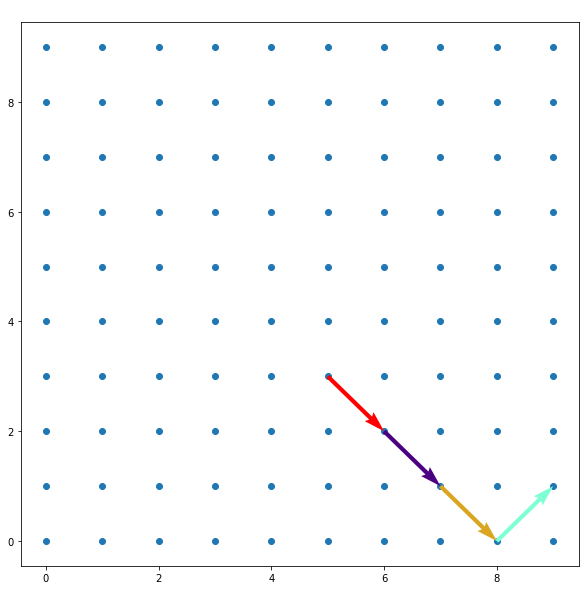

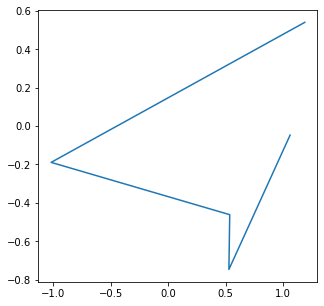

In [0]:
def get_data_by_idx(data_loader, idx):
  return [d for (i, d) in enumerate(data_loader) if i == idx][0]

idx = random.randint(0, len(test_loader))
items = get_data_by_idx(test_loader, idx)
show_movement(items[0][0], items[1][0])

embed = get_data_by_idx(test_loader_int, idx)
embedding = nn.Embedding(conf_embed.vocab_size, conf_embed.embedding_dim)
embed = embedding(embed[0]).detach().numpy()[0]
fig = plt.figure(figsize=(5,5))
plt.plot(embed[:,0], embed[:,1])
fig.show()


## Distance change in embeddings

In [252]:
conf_embed = Config(bs=4, 
                    epochs=1, 
                    output=4, 
                    inputs=2, 
                    hidden=512, 
                    seq_len=5, 
                    layers=2, 
                    trunc=False, 
                    embedding=True, 
                    vocab_size=100,
                    embedding_dim=2,
                    lr=0.0005)
model_embed = RNNetEmbed(conf_embed)
model_embed.cuda()
train(model_embed, conf_embed, test_loader_int, test_loader_int)


Train epoch 0, idx: 0	 Loss 1.3952	 Acc: 23.90%
Train epoch 0, idx: 100	 Loss 1.3952	 Acc: 28.50%
Train epoch 0, idx: 200	 Loss 1.3256	 Acc: 26.80%


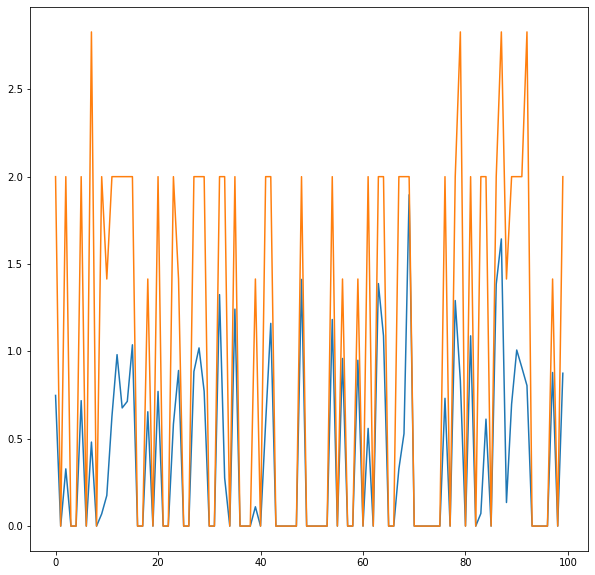

In [256]:
from math import sqrt

def dist(a, b):
  x1, y1 = a
  x2, y2 = b
  return sqrt((x2-x1)**2 + (y2-y1)**2)

def distances(series):
  d = []
  for i, x in enumerate(series):
    for j, y in enumerate(series):
      if (abs(i - j) > 1):
        d.append(dist(x, y))
  return min(d)

X = list(range(len(test_loader) * conf.bs))
y1 = []
y2 = []
for e in model_embed.embs:
  e = e.cpu().numpy()
  for batch in e:
    y1.append(distances(batch))

for data in test_loader:
  for batch in data[0].numpy():
    y2.append(distances(batch))

fig = plt.figure(figsize=(10,10))
plt.plot(X[:100], y1[:100])
plt.plot(X[:100], y2[:100])
fig.show()